In [3]:
import paho.mqtt.client as mqtt
import json
import numpy as np
import xgboost as xgb
from numpy import linalg

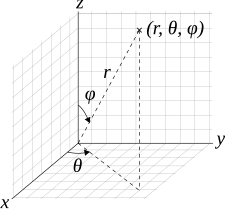

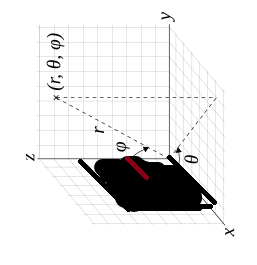

Nesse caso a ancora estara no plano XZ. $\phi$ é azimuth e $\theta$ é a elevação, raio será sempre 1 pq só apontamos a uma direção

$ x= r cos\theta \sin phi$ \
$ y= r sin\theta \sin phi$ \
$ z= r cos\theta $ 

In [ ]:
get_direction= lambda phi,theta : (np.cos(theta,deg=True)*np.sin(phi,deg=True),
                                   np.sin(theta,deg=True)*np.sin(phi,deg=True),
                                   np.cos(phi))

Suponha que tenhamos um  outra ancora poscionada uma distância $d$ so sentido crescrente do plano z. Ou seja se A está em (0,0,0),  B está em (0,0,d) \
Reta no R3: $r=P + kv$ \
Equação da reta A (0,0,0) => (xa,ya,za): $[x,y,z] = 0 + t*[xa,ya,za]$ \
Equação da reta B (0,0,D) => (xb,yb,zb): $[x,y,z] = [0,0,d] + k*[xb,yb,zb-d]$ \

*Mudança de coordenadas*

Logo o ponto de encontro será encontrado resolvendo o  sistema linear \
$t*xa - k*xb = 0$ \
$t*ya - k*yb = 0$\
$t*za - (d + k*(zb-d)) = 0$

$t = ya \cdot xb - xa \cdot yb$


In [ ]:
def posicioner(A,B,d):
    B -= (0,0,d)
    return linalg.solve(A,-B, (0,0,d))

In [ ]:

model = xgb.XGBRegressor()
model.load_model("./regressor.json")

# Callback chamado quando o cliente recebe a resposta CONNACK do servidor.
def on_connect(client, userdata, flags, rc):
    print("Conectado com o código de resultado "+str(rc))
    client.subscribe("/gw/ac233fc09283/status")
    
# Callback chamado quando uma mensagem PUBLISH é recebida do servidor.
#antenna array configuration: 2,2,0,5,6,1,12,14

def on_message(client, userdata, msg):
    data = json.loads(msg.payload)

    predictions_azi =[]
    predictions_el =[]
    for i in range(16,len(data[1]["aoa"]["iq"])-6,3*2):
        prediction = model.predict([data[1]["aoa"]["iq"][i:i+6]])
        if (i-16) %2 == 0:
            #0,5,6
            predictions_azi.append(prediction)
        else:
            #1,12,14
            predictions_el.append(prediction)


    print(f''' 
        azimuth = {np.mean(predictions_el)} \n
        elevation = {np.mean(predictions_el)} \n 
    ''')

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("broker.hivemq.com", 1883, 60)

client.loop_forever()